# Twitter Video Game Analytics

Questions: How does the number of tweets correspond to the ratings of the videogame? And the sales? 
Is the analysis the same for all the continents or are there outliers? 


Does sales differ between the continents and correlate the location of the business?
How can we relate the number of tweets to sales? 


In [49]:
from geopy.geocoders import Nominatim
from requests_oauthlib import OAuth1
from pandas.io.json import json_normalize
from collections import OrderedDict
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import us
import tweepy
import json
import seaborn as sns
import re
import geocoder
import pandas as pd
import numpy as np
import fiona

In [59]:
def country_to_continents(country):
    state_continents = {"AD":"Europe","AE":"Asia","AF":"Asia","AG":"North America",
    "AI":"North America","AL":"Europe","AM":"Asia","AN":"North America","AO":"Africa","AQ":"Antarctica","AR":"South America","AS":"Australia","AT":"Europe",
    "AU":"Australia","AW":"North America","AZ":"Asia","BA":"Europe","BB":"North America","BD":"Asia","BE":"Europe","BF":"Africa","BG":"Europe","BH":"Asia","BI":"Africa","BJ":"Africa","BM":"North America","BN":"Asia","BO":"South America","BR":"South America",
    "BS":"North America","BT":"Asia","BW":"Africa","BY":"Europe","BZ":"North America","CA":"North America","CC":"Asia","CD":"Africa","CF":"Africa","CG":"Africa","CH":"Europe","CI":"Africa","CK":"Australia","CL":"South America","CM":"Africa","CN":"Asia",
    "CO":"South America","CR":"North America","CU":"North America","CV":"Africa","CX":"Asia","CY":"Asia","CZ":"Europe","DE":"Europe","DJ":"Africa","DK":"Europe","DM":"North America","DO":"North America","DZ":"Africa","EC":"South America","EE":"Europe","EG":"Africa",
    "EH":"Africa","ER":"Africa","ES":"Europe","ET":"Africa","FI":"Europe","FJ":"Australia","FK":"South America","FM":"Australia","FO":"Europe","FR":"Europe","GA":"Africa","GB":"Europe","GD":"North America","GE":"Asia","GF":"South America","GG":"Europe","GH":"Africa",
    "GI":"Europe","GL":"North America","GM":"Africa","GN":"Africa","GP":"North America","GQ":"Africa","GR":"Europe","GS":"Antarctica","GT":"North America","GU":"Australia","GW":"Africa","GY":"South America","HK":"Asia","HN":"North America","HR":"Europe",
    "HT":"North America","HU":"Europe","ID":"Asia","IE":"Europe","IL":"Asia","IM":"Europe","IN":"Asia","IO":"Asia","IQ":"Asia","IR":"Asia","IS":"Europe","IT":"Europe","JE":"Europe","JM":"North America","JO":"Asia","JP":"Asia","KE":"Africa","KG":"Asia","KH":"Asia",
    "KI":"Australia","KM":"Africa","KN":"North America","KP":"Asia","KR":"Asia","KW":"Asia","KY":"North America","KZ":"Asia","LA":"Asia","LB":"Asia","LC":"North America","LI":"Europe","LK":"Asia","LR":"Africa","LS":"Africa","LT":"Europe","LU":"Europe","LV":"Europe",
    "LY":"Africa","MA":"Africa","MC":"Europe","MD":"Europe","ME":"Europe","MG":"Africa","MH":"Australia","MK":"Europe","ML":"Africa","MM":"Asia","MN":"Asia","MO":"Asia","MP":"Australia","MQ":"North America","MR":"Africa","MS":"North America","MT":"Europe","MU":"Africa",
    "MV":"Asia","MW":"Africa","MX":"North America","MY":"Asia","MZ":"Africa","NA":"Africa","NC":"Australia","NE":"Africa","NF":"Australia","NG":"Africa","NI":"North America","NL":"Europe","NO":"Europe","NP":"Asia","NR":"Australia","NU":"Australia","NZ":"Australia",
    "OM":"Asia","PA":"North America","PE":"South America","PF":"Australia","PG":"Australia","PH":"Asia","PK":"Asia","PL":"Europe","PM":"North America","PN":"Australia","PR":"North America","PS":"Asia","PT":"Europe","PW":"Australia","PY":"South America","QA":"Asia",
    "RE":"Africa","RO":"Europe","RS":"Europe","RU":"Europe","RW":"Africa","SA":"Asia","SB":"Australia","SC":"Africa","SD":"Africa","SE":"Europe","SG":"Asia","SH":"Africa","SI":"Europe","SJ":"Europe","SK":"Europe","SL":"Africa","SM":"Europe","SN":"Africa",
    "SO":"Africa","SR":"South America","ST":"Africa","SV":"North America","SY":"Asia","SZ":"Africa","TC":"North America","TD":"Africa","TF":"Antarctica","TG":"Africa","TH":"Asia","TJ":"Asia","TK":"Australia","TM":"Asia","TN":"Africa","TO":"Australia",
    "TR":"Asia","TT":"North America","TV":"Australia","TW":"Asia","TZ":"Africa","UA":"Europe","UG":"Africa","US":"North America","UY":"South America",
    "UZ":"Asia","VC":"North America","VE":"South America","VG":"North America","VI":"North America","VN":"Asia","VU":"Australia","WF":"Australia","WS":"Australia","YE":"Asia","YT":"Africa","ZA":"Africa","ZM":"Africa","ZW":"Africa"}

    for k,v in state_continents.items():
        if country == k:
            return v
    return None


In [ ]:
def plot_signal(x,y):
    plt.figure(figsize=(8, 10))
    ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
    ax1.set_global()
    ax1.coastlines()
    ax1.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree(central_longitude=0))
    ax1.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree(central_longitude=0))
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.stock_img()
    ax1.scatter(x,y,transform=ccrs.PlateCarree())
    return ax1

In [45]:
def finding_locations(search_text):
    search_results = []
    for status in tweepy.Cursor(api.search, q=search_text,retweeted_status=False).items(1000):
        search_results.append(status._json)   
    with open('search_results.json', 'w') as file:
        json.dump(search_results,file)
    
    def byteify(input):
        if isinstance(input, dict):
            return {byteify(key): byteify(value)
                    for key, value in input.iteritems()}
        elif isinstance(input, list):
            return [byteify(element) for element in input]
        elif isinstance(input, unicode):
            return input.encode('utf-8')
        else:
            return input
    
    json_df = json.load((open('search_results.json')),object_hook=byteify)
    json_df = json_normalize(json_df)
    json_df = json_df.dropna(how='all',axis=1)
    json_df = json_df[json_df['user.location'] != '']
    
    def match_boolean(text):
        if not text:
            return False
        else:
            if re.search(r"\s*[,]\s*", str(text)):
                text = text.split(', ')
            elif re.search('(?<=-)\w+', str(text)):
                text = text.split('-')
            return True 
    
    us_comments = pd.DataFrame()
    appended_data = {}
    for each in json_df['user.location']:
        match = match_boolean(each)
        if match:
            appended_data[each] = json_df[json_df['user.location'] == each]
    us_comments = appended_data

    temp_coords = []
    for each in us_comments:
        geo = geocoder.google(each,key=google)
        temp_coords.append([geo.city, geo.state, geo.state_long, geo.country, geo.country_long, country_to_continents(geo.country), geo.lat, geo.lng])
        
    clean_df = pd.DataFrame(data=temp_coords, columns=['city','state','state_long','country','country_long', 'continent', 'lat','lng'])
    return clean_df

In [46]:
ratings = pd.read_csv('../Capstone Project/Data/ign.csv').fillna(value=0.0)
sales = pd.read_csv('../Capstone Project/Data/Video_Games_Sales_as_at_22_Dec_2016 2.csv').fillna(value=0.0)

In [51]:
file = '../twitter.xlsx'
data = list(pd.read_excel(file,header=1))
access_token = str(data[0])
access_token_secret = str(data[1])
consumer_key = str(data[2])
consumer_secret = str(data[3])
google = str(data[4])

auth = tweepy.OAuthHandler(consumer_key, consumer_secret,'https://api.twitter.com/1.1/tweets/search/fullarchive/1.json')
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth)
no_space_names = pd.DataFrame(
    np.core.defchararray.replace(sales['Name'].values.astype(str), ' ', ''))
search_list = list("%23" + no_space_names.values)
num = 3
search_list = pd.DataFrame(search_list[:num])
videogames = sales['Name'].loc[:num]
keywords = dict(zip(videogames.values,search_list.values))

clean_dict = {}
for k,v in keywords.iteritems():
    clean_dict[k] = finding_locations(v)

clean_df = {(outerKey, innerKey): values for outerKey, innerDict in clean_dict.iteritems() for innerKey, values in innerDict.iteritems()}
clean_df = pd.DataFrame(clean_df)

for videogame in videogames[::(len(videogames)-1)]]:
    ax = plot_signal(clean_df[videogame]['lng'].values,clean_df[videogame]['lat'].values)
plt.show()

SyntaxError: invalid syntax (<ipython-input-51-0035c3e10f27>, line 27)

In [44]:
clean_df.dropna(how='all').head()

NameError: name 'clean_df' is not defined

In [ ]:
sales['Genre'].value_counts(dropna=True)

In [ ]:
sales.groupby(['Genre','Platform']).plot(kind = 'box',fontsize = 15)
plt.show()

In [ ]:
ax1 = plt.subplot(3, 1, 1)
ax1.scatter(sales['User_Count'].values, sales['EU_Sales'].values)
plt.title('Videogames')
ax1.legend()
ax1.set_ylabel('Continent Sales')

ax2 = plt.subplot(3, 1, 2,sharex=ax1)
ax2.scatter(sales['User_Count'].values ,sales['JP_Sales'].values)
ax2.set_ylabel('Japanese')

ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.scatter(sales['User_Count'].values ,sales['NA_Sales'].values)
ax3.set_xlabel('Year')
ax3.set_ylabel('North America')
plt.show()

In [ ]:
value_counts = []
for videogame in videogames[:(len(videogames)-1)]:
    value_counts.append([videogame,clean_df[videogame].continent.value_counts()])

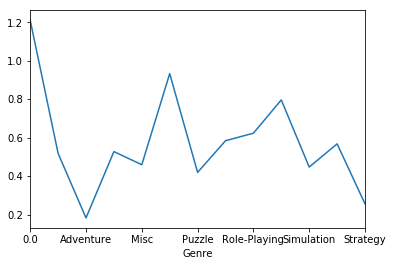

In [6]:
sales.groupby('Genre')['Global_Sales'].mean().plot()
plt.show()

In [7]:
print sales.columns
print ratings.columns

Index([u'Name', u'Platform', u'Year_of_Release', u'Genre', u'Publisher',
       u'NA_Sales', u'EU_Sales', u'JP_Sales', u'Other_Sales', u'Global_Sales',
       u'Critic_Score', u'Critic_Count', u'User_Score', u'User_Count',
       u'Developer', u'Rating'],
      dtype='object')
Index([u'Unnamed: 0', u'score_phrase', u'title', u'url', u'platform', u'score',
       u'genre', u'editors_choice', u'release_year', u'release_month',
       u'release_day'],
      dtype='object')


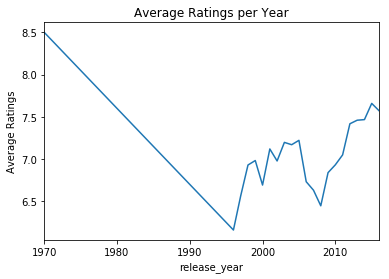

In [8]:
ratings.groupby('release_year')['score'].mean().plot(legend=False)
plt.title('Average Ratings per Year')
plt.ylabel('Average Ratings')
plt.show()

In [9]:
ratings.groupby('genre')['score'].mean()

genre
0.0                         6.747222
Action                      6.626679
Action, Adventure           7.371895
Action, Compilation         7.029213
Action, Editor              7.500000
Action, Platformer          6.066667
Action, Puzzle              6.000000
Action, RPG                 7.464848
Action, Simulation          7.059375
Action, Strategy            7.600000
Adult, Card                 6.050000
Adventure                   6.864851
Adventure, Adult            4.100000
Adventure, Adventure        6.680000
Adventure, Compilation      7.600000
Adventure, Episodic         8.900000
Adventure, Platformer       8.600000
Adventure, RPG              7.833333
Baseball                    4.500000
Battle                      6.212500
Board                       6.625862
Board, Compilation          6.400000
Card                        6.707407
Card, Battle                7.157407
Card, Compilation           6.666667
Card, RPG                   7.888889
Casino                      5.12

In [10]:
sales['Platform'].value_counts()

PS2     2161
DS      2152
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      432
PS4      393
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       29
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: Platform, dtype: int64

In [11]:
ratings.groupby(['score'], sort=False).sum()

,Unnamed: 0,release_year,release_month,release_day
score,,,,
9.0,9008322,1840725,6540,14583
8.5,11040240,2059844,7002,16144
7.0,14848173,3156084,11252,23612
3.0,2393036,593539,2036,4699
7.5,11753012,2180466,7671,17267
6.5,8108342,1551739,5402,12047
8.0,17565153,3528050,12380,27999
5.5,5512479,1057853,3910,7905
8.7,1820078,451239,1691,3576


In [15]:
!pip install python-twitter

In [41]:
from twitter import *
import pandas as pd

file = '../../twitter.xlsx'
data = list(pd.read_excel(file,header=1))
access_token = str(data[0])
access_token_secret = str(data[1])
consumer_key = str(data[2])
consumer_secret = str(data[3])
google = str(data[4])

api = Twitter(auth=OAuth(consumer_key=consumer_key,
                  consumer_secret=consumer_secret,
                  token=access_token,
                  token_secret=access_token_secret,
                  ), domain='https://api.twitter.com',api_version='v1.1')

In [42]:
api.search.tweets(q="#pycon")

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [53]:
import tweepy
file = '../../twitter.xlsx'
data = list(pd.read_excel(file,header=1))
access_token = str(data[0])
access_token_secret = str(data[1])
consumer_key = str(data[2])
consumer_secret = str(data[3])
google = str(data[4])

auth = tweepy.OAuthHandler(consumer_key, consumer_secret,'https://api.twitter.com/1.1/tweets/search/fullarchive/1.json')
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth)

In [75]:
def tweets_locations(search_text):
    temp_coords = []
    search_results = []

    for status in tweepy.Cursor(api.search, q=search_text).items(10):
        search_results.append(status._json)

    json_df = search_results
    json_df = json_normalize(json_df)
    json_df = json_df.dropna(how='all',axis=1)
    json_df = json_df[json_df['user.location'] != '']

    us_comments = pd.DataFrame()
    appended_data = {}
    for each in json_df['user.location']:
        appended_data[each] = json_df[json_df['user.location'] == each]
    us_comments = appended_data

    temp_coords = []

    for each in us_comments:
        geo = geocoder.google(each,key=google)
        temp_coords.append([geo.city, geo.state, geo.state_long, geo.country, geo.country_long, country_to_continents(geo.country), geo.lat, geo.lng])

    clean_df = pd.DataFrame(data=temp_coords, columns=['city','state','state_long','country','country_long', 'continent', 'lat','lng'])
    return clean_df, us_comments

In [76]:
print tweets_locations('Wii Sports')

(           city state       state_long country   country_long      continent  \
0        Mumbai    MH      Maharashtra      IN          India           Asia   
1          None    VA         Virginia      US  United States  North America   
2          None    WA       Washington      US  United States  North America   
3      Adelaide    SA  South Australia      AU      Australia      Australia   
4          None    PA     Pennsylvania      US  United States  North America   
5  Independence    KS           Kansas      US  United States  North America   
6        Tucson    AZ          Arizona      US  United States  North America   

         lat         lng  
0  19.229190   72.848518  
1  37.431573  -78.656894  
2  47.751074 -120.740139  
3 -34.928499  138.600746  
4  41.203322  -77.194525  
5  37.224898  -95.709940  
6  32.251046 -110.973851  , {u'Unova Region ;3':                        created_at entities.hashtags entities.media  \
4  Wed Feb 28 16:30:46 +0000 2018                [

In [80]:
!pip install selenium
!pip install tweepy

In [83]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException
from time import sleep
import json
import datetime


# edit these three variables
user = 'Wii Sport'
start = datetime.datetime(2010, 1, 1)  # year, month, day
end = datetime.datetime(2016, 12, 7)  # year, month, day

# only edit these if you're having problems
delay = 1  # time to wait on each page load before reading the page
driver = webdriver.Safari()  # options are Chrome() Firefox() Safari()


# don't mess with this stuff
twitter_ids_filename = 'all_ids.json'
days = (end - start).days + 1
id_selector = '.time a.tweet-timestamp'
tweet_selector = 'li.js-stream-item'
user = user.lower()
ids = []

def format_day(date):
    day = '0' + str(date.day) if len(str(date.day)) == 1 else str(date.day)
    month = '0' + str(date.month) if len(str(date.month)) == 1 else str(date.month)
    year = str(date.year)
    return '-'.join([year, month, day])

def form_url(since, until):
    p1 = 'https://twitter.com/search?f=tweets&vertical=default&q=from%3A'
    p2 =  user + '%20since%3A' + since + '%20until%3A' + until + 'include%3Aretweets&src=typd'
    return p1 + p2

def increment_day(date, i):
    return date + datetime.timedelta(days=i)

for day in range(days):
    d1 = format_day(increment_day(start, 0))
    d2 = format_day(increment_day(start, 1))
    url = form_url(d1, d2)
    print(url)
    print(d1)
    driver.get(url)
    sleep(delay)

    try:
        found_tweets = driver.find_elements_by_css_selector(tweet_selector)
        increment = 10

        while len(found_tweets) >= increment:
            print('scrolling down to load more tweets')
            driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
            sleep(delay)
            found_tweets = driver.find_elements_by_css_selector(tweet_selector)
            increment += 10

        print('{} tweets found, {} total'.format(len(found_tweets), len(ids)))

        for tweet in found_tweets:
            try:
                id = tweet.find_element_by_css_selector(id_selector).get_attribute('href').split('/')[-1]
                ids.append(id)
            except StaleElementReferenceException as e:
                print('lost element reference', tweet)

    except NoSuchElementException:
        print('no tweets on this day')

    start = increment_day(start, 1)


try:
    with open(twitter_ids_filename) as f:
        all_ids = ids + json.load(f)
        data_to_write = list(set(all_ids))
        print('tweets found on this scrape: ', len(ids))
        print('total tweet count: ', len(data_to_write))
except FileNotFoundError:
    with open(twitter_ids_filename, 'w') as f:
        all_ids = ids
        data_to_write = list(set(all_ids))
        print('tweets found on this scrape: ', len(ids))
        print('total tweet count: ', len(data_to_write))

with open(twitter_ids_filename, 'w') as outfile:
    json.dump(data_to_write, outfile)

print('all done here')
driver.close()

SessionNotCreatedException: Message: Could not create a session: You must enable the 'Allow Remote Automation' option in Safari's Develop menu to control Safari via WebDriver.


In [105]:
!pip install oauth2

    100% |████████████████████████████████| 204kB 2.0MB/s ta 0:00:01
  Running setup.py bdist_wheel for httplib2 ... done
  Stored in directory: /Users/SarahsAdventure/Library/Caches/pip/wheels/ca/ac/5f/749651f7925b231103f5316cacca82a487810c22d30f011c0c
Successfully built httplib2


In [115]:
import random;
import string
import time
import urllib
import urllib2
from urlparse import urlparse

import hmac
import hashlib
import requests
from requests_oauthlib import OAuth1


access_token = str(data[0])
access_token_secret = str(data[1])
consumer_key = str(data[2])
consumer_secret = str(data[3])

url = 'https://api.twitter.com/1.1/tweets/search/full-archive/Sandbox.json'
auth = OAuth1(consumer_key, consumer_secret, access_token, access_token_secret)
response = requests.get(url, auth=auth)
print response.content

#post_params = urllib.urlencode(post_params);
#request = urllib2.Request(url, post_params, method);
#response = urllib2.urlopen(request);
#response_string = response.read();

print response.status_code

{"error":{"message":"Forbidden: Authentication succeeded but account is not authorized to access this resource.","sent":"2018-03-01T00:33:48+00:00","transactionId":"0070694100372afa"}}
403


In [116]:
!pip install searchtweets

  Running setup.py bdist_wheel for searchtweets ... done
  Stored in directory: /Users/SarahsAdventure/Library/Caches/pip/wheels/8a/5a/a7/00bdd28ed7c9c9716bc36f37664f56f9ae12a996b8a9e94070
  Running setup.py bdist_wheel for tweet-parser ... done
  Stored in directory: /Users/SarahsAdventure/Library/Caches/pip/wheels/24/9a/8d/a7222c312d2579eddbcd0f4505d5c0dcd60dcffc876618f7eb
Successfully built searchtweets tweet-parser


In [130]:
from searchtweets import load_credentials

premium_search_args = load_credentials(filename="./search_tweets_creds_example.yaml",
                 yaml_key="search_tweets_api")


SyntaxError: invalid syntax (utils.py, line 80)

In [132]:
import twitter
api = twitter.Api(consumer_key=[consumer_key],
                  consumer_secret=[consumer_secret],
                  access_token_key=[access_token],
                  access_token_secret=[access_token_secret])


AttributeError: 'module' object has no attribute 'Api'